In [2]:
import tensorflow as tf

In [ ]:
!pip install tensorflow-gan
!pip install tensorflow-datasets
!pip install matplotlib

In [6]:
import tensorflow.compat.v1 as tf
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)  # Disable noisy outputs.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 8.5 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 22.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 7.3 MB/s eta 0:00:00


In [7]:
import tensorflow_datasets as tfds
import tensorflow.compat.v1 as tf

def input_fn(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tf.estimator.ModeKeys.PREDICT)
  
  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random.normal([bs, nd])))
  
  if just_noise:
    return noise_ds

  def _preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('mnist:3.*.*', split=split)
               .map(_preprocess)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))

2023-03-23 21:32:44.351608: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /Users/tn_family/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2023-03-23 21:32:48.872482: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-23 21:32:48.876730: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-23 21:32:49.135066: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:32:49.135400: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline simil

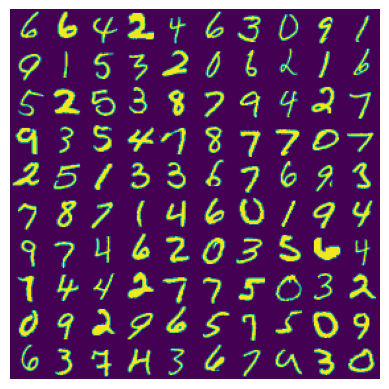

In [8]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import numpy as np

params = {'batch_size': 100, 'noise_dims':64}
with tf.Graph().as_default():
  ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
  numpy_imgs = next(iter(tfds.as_numpy(ds)))[1]
img_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(10, 10))
plt.axis('off')
plt.imshow(np.squeeze(img_grid))
plt.show()

In [9]:
def _dense(inputs, units, l2_weight):
  return tf.layers.dense(
      inputs, units, None,
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _batch_norm(inputs, is_training):
  return tf.layers.batch_normalization(
      inputs, momentum=0.999, epsilon=0.001, training=is_training)

def _deconv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.layers.conv2d_transpose(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=tf.nn.relu, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _conv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.layers.conv2d(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=None, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

In [10]:
def unconditional_generator(noise, mode, weight_decay=2.5e-5):
  """Generator to produce unconditional MNIST images."""
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  
  net = _dense(noise, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)
  
  net = _dense(net, 7 * 7 * 256, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)
  
  net = tf.reshape(net, [-1, 7, 7, 256])
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  # Make sure that generator output is in the same range as `inputs`
  # ie [-1, 1].
  net = _conv2d(net, 1, 4, 1, 0.0)
  net = tf.tanh(net)

  return net

In [11]:
_leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)

def unconditional_discriminator(img, unused_conditioning, mode, weight_decay=2.5e-5):
  del unused_conditioning
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  
  net = _conv2d(img, 64, 4, 2, weight_decay)
  net = _leaky_relu(net)
  
  net = _conv2d(net, 128, 4, 2, weight_decay)
  net = _leaky_relu(net)
  
  net = tf.layers.flatten(net)
  
  net = _dense(net, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = _leaky_relu(net)
  
  net = _dense(net, 1, weight_decay)

  return net

In [12]:
from tensorflow_gan.examples.mnist import util as eval_util
import os

def get_eval_metric_ops_fn(gan_model):
  real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
  gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)
  real_mnist_score = eval_util.mnist_score(gan_model.real_data)
  generated_mnist_score = eval_util.mnist_score(gan_model.generated_data)
  frechet_distance = eval_util.mnist_frechet_distance(
      gan_model.real_data, gan_model.generated_data)
  return {
      'real_data_logits': tf.metrics.mean(real_data_logits),
      'gen_data_logits': tf.metrics.mean(gen_data_logits),
      'real_mnist_score': tf.metrics.mean(real_mnist_score),
      'mnist_score': tf.metrics.mean(generated_mnist_score),
      'frechet_distance': tf.metrics.mean(frechet_distance),
  }

In [13]:
train_batch_size = 32 #@param
noise_dimensions = 64 #@param
generator_lr = 0.001 #@param
discriminator_lr = 0.0002 #@param

def gen_opt():
  gstep = tf.train.get_or_create_global_step()
  base_lr = generator_lr
  # Halve the learning rate at 1000 steps.
  lr = tf.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
  return tf.train.AdamOptimizer(lr, 0.5)

gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=unconditional_generator,
    discriminator_fn=unconditional_discriminator,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    params={'batch_size': train_batch_size, 'noise_dims': noise_dimensions},
    generator_optimizer=gen_opt,
    discriminator_optimizer=tf.train.AdamOptimizer(discriminator_lr, 0.5),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn)

/var/folders/f7/v259x6_d7cd3fv86tzwj7m100000gn/T/ipykernel_63664/1590621595.py:2: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/var/folders/f7/v259x6_d7cd3fv86tzwj7m100000gn/T/ipykernel_63664/1590621595.py:9: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  return tf.layers.batch_normalization(
/var/folders/f7/v259x6_d7cd3fv86tzwj7m100000gn/T/ipykernel_63664/1590621595.py:13: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  return tf.layers.conv2d_transpose(
/var/folders/f7/v259x6_d7cd3fv86tzwj7m100000gn/T/ipykernel_63

Time since start: 1.32 min
Trained from step 0 to 500 in 6.33 steps / sec


2023-03-23 21:35:48.530853: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:35:48.531373: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Average discriminator output on Real: -12.50  Fake: -11.21
Inception Score: 5.70 / 8.35  Frechet Distance: 90.58


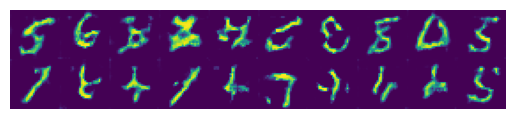

2023-03-23 21:37:09.460054: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:37:09.524734: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Time since start: 2.78 min
Trained from step 500 to 1000 in 6.26 steps / sec


2023-03-23 21:37:15.124832: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:37:15.125507: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Average discriminator output on Real: -4.82  Fake: -4.99
Inception Score: 6.78 / 8.35  Frechet Distance: 68.66


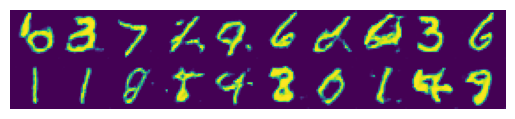

2023-03-23 21:38:34.295258: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:38:34.350176: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Time since start: 4.19 min
Trained from step 1000 to 1500 in 6.33 steps / sec


2023-03-23 21:38:39.886014: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:38:39.886728: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Average discriminator output on Real: -16.11  Fake: -17.26
Inception Score: 7.18 / 8.35  Frechet Distance: 61.33


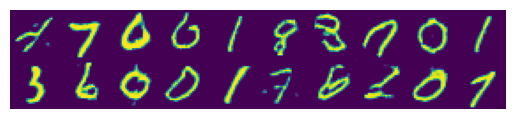

2023-03-23 21:40:03.616667: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:40:03.701974: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Time since start: 5.68 min
Trained from step 1500 to 2000 in 5.98 steps / sec


2023-03-23 21:40:12.351105: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:40:12.353714: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Average discriminator output on Real: -14.00  Fake: -15.48
Inception Score: 7.19 / 8.35  Frechet Distance: 56.44


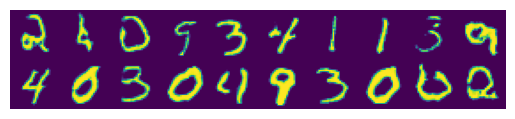

2023-03-23 21:41:39.668051: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:41:39.746480: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Time since start: 7.28 min
Trained from step 2000 to 2500 in 5.74 steps / sec


2023-03-23 21:41:46.128891: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:41:46.130532: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Average discriminator output on Real: 3.44  Fake: 0.61
Inception Score: 7.16 / 8.35  Frechet Distance: 57.78


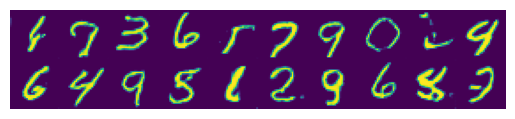

2023-03-23 21:43:08.045846: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:43:08.089575: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Time since start: 8.75 min
Trained from step 2500 to 3000 in 6.12 steps / sec


2023-03-23 21:43:14.328803: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:43:14.329438: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Average discriminator output on Real: 23.71  Fake: 16.94
Inception Score: 7.26 / 8.35  Frechet Distance: 63.45


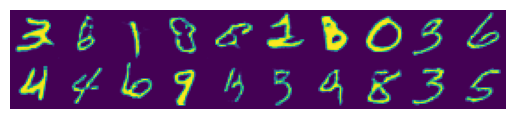

2023-03-23 21:44:35.930713: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:44:35.947543: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Time since start: 10.22 min
Trained from step 3000 to 3500 in 6.14 steps / sec


2023-03-23 21:44:41.452802: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:44:41.453512: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Average discriminator output on Real: 118.62  Fake: 113.06
Inception Score: 7.42 / 8.35  Frechet Distance: 57.05


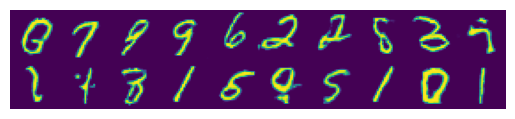

2023-03-23 21:46:05.145919: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:46:05.220202: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Time since start: 11.71 min
Trained from step 3500 to 4000 in 5.98 steps / sec


2023-03-23 21:46:14.334101: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:46:14.335813: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Average discriminator output on Real: 98.84  Fake: 83.94
Inception Score: 7.32 / 8.35  Frechet Distance: 61.32


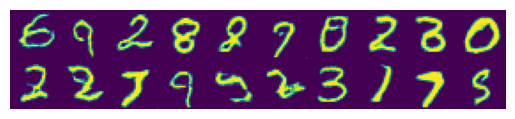

2023-03-23 21:47:44.991895: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:47:45.045240: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Time since start: 13.37 min
Trained from step 4000 to 4500 in 5.53 steps / sec


2023-03-23 21:47:52.290258: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:47:52.291989: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Average discriminator output on Real: 27.84  Fake: 28.08
Inception Score: 7.42 / 8.35  Frechet Distance: 61.37


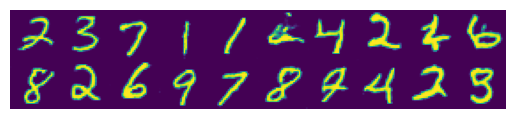

2023-03-23 21:49:23.649873: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:49:23.746016: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Time since start: 15.02 min
Trained from step 4500 to 5000 in 5.48 steps / sec


2023-03-23 21:49:29.614116: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-23 21:49:29.614859: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Average discriminator output on Real: 119.15  Fake: 106.55
Inception Score: 7.55 / 8.35  Frechet Distance: 54.50


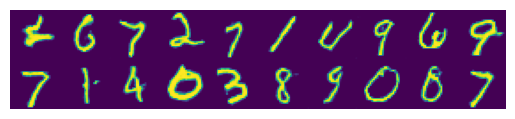

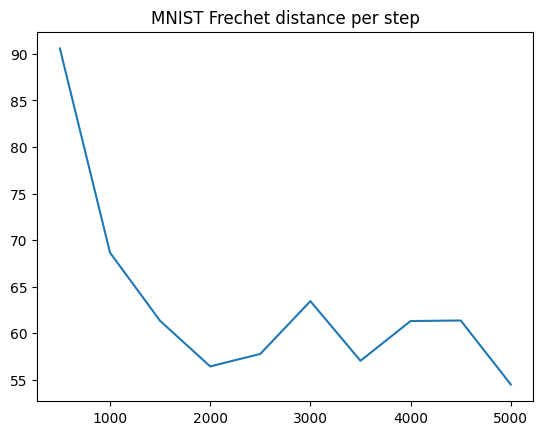

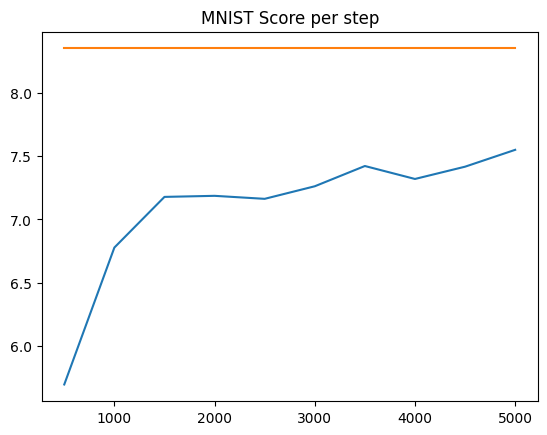

In [14]:
# Disable noisy output.
tf.autograph.set_verbosity(0, False)

import time
steps_per_eval = 500 #@param
max_train_steps = 5000 #@param
batches_for_eval_metrics = 100 #@param

# Used to track metrics.
steps = []
real_logits, fake_logits = [], []
real_mnist_scores, mnist_scores, frechet_distances = [], [], []

cur_step = 0
start_time = time.time()
while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)

  start = time.time()
  gan_estimator.train(input_fn, max_steps=next_step)
  steps_taken = next_step - cur_step
  time_taken = time.time() - start
  print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
  print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))
  cur_step = next_step
  
  # Calculate some metrics.
  metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics)
  steps.append(cur_step)
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  real_mnist_scores.append(metrics['real_mnist_score'])
  mnist_scores.append(metrics['mnist_score'])
  frechet_distances.append(metrics['frechet_distance'])
  print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
      real_logits[-1], fake_logits[-1]))
  print('Inception Score: %.2f / %.2f  Frechet Distance: %.2f' % (
      mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))
  
  # Vizualize some images.
  iterator = gan_estimator.predict(
      input_fn, hooks=[tf.train.StopAtStepHook(num_steps=21)])
  try:
    imgs = np.array([next(iterator) for _ in range(20)])
  except StopIteration:
    pass
  tiled = tfgan.eval.python_image_grid(imgs, grid_shape=(2, 10))
  plt.axis('off')
  plt.imshow(np.squeeze(tiled))
  plt.show()
  
  
# Plot the metrics vs step.
plt.title('MNIST Frechet distance per step')
plt.plot(steps, frechet_distances)
plt.figure()
plt.title('MNIST Score per step')
plt.plot(steps, mnist_scores)
plt.plot(steps, real_mnist_scores)
plt.show()